In [1]:
from catboost import  CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline

import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\프로그램\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
data = pd.read_csv('../datasets/BankChurners_change.csv', encoding='CP949')
data = data.iloc[:,2:23]
np.random.seed(42)
random.seed(42)

In [20]:
object_columns = data.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(data[i])
    data[i] = lb.transform(data[i])
    
    print(f'category : {np.unique(data[i])}\nclasses : {lb.classes_}\n')

input = data.iloc[:,1:]
target = data.iloc[:,0]

category : [0 1]
classes : ['Attrited Customer' 'Existing Customer']

category : [0 1]
classes : ['F' 'M']

category : [0 1 2 3 4 5 6]
classes : ['College' 'Doctorate' 'Graduate' 'High School' 'Post-Graduate'
 'Uneducated' 'Unknown']

category : [0 1 2 3]
classes : ['Divorced' 'Married' 'Single' 'Unknown']

category : [0 1 2 3 4 5]
classes : ['$120K +' '$40K - $60K' '$60K - $80K' '$80K - $120K' 'Less than $40K'
 'Unknown']

category : [0 1 2 3]
classes : ['Blue' 'Gold' 'Platinum' 'Silver']

category : [0 1 2 3 4]
classes : ['20대' '30대' '40대' '50대' '60대 이상']



## Under Sampling

In [4]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks]

for i in sampling:
    
    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    if i == OneSidedSelection:
        sampling = i(random_state=42)
    else:
        sampling = i()

    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    df.loc[i.__name__] = [f1, recall, precision, acc]

print("Cat Model's score by Under sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False)

Cat Model's score by Under sampling


f1_score    recall  precision  accuracy
TomekLinks                       0.983021  0.988228   0.977868  0.971372
OneSidedSelection                0.982415  0.986463   0.978400  0.970385
EditedNearestNeighbours          0.980798  0.977045   0.984579  0.967917
AllKNN                           0.980764  0.975280   0.986310  0.967917
NeighbourhoodCleaningRule        0.980519  0.977634   0.983422  0.967423
RepeatedEditedNearestNeighbours  0.979241  0.971748   0.986850  0.965449
NearMiss                         0.949786  0.912890   0.989789  0.919052

## Over Sampling

In [10]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [SMOTE, BorderlineSMOTE, ADASYN]
strategy_ = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in sampling:
    
    for strategy in strategy_:
        x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

        ss = StandardScaler()
        x_train_ss = ss.fit_transform(x_train)
        x_test_ss = ss.fit_transform(x_test)

        sampling = i(sampling_strategy=strategy, random_state=42)
        x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

        cat = CatBoostClassifier(random_state=42, verbose=0)
        cat.fit(x_train_ss, y_train)
        pred = cat.predict(x_test_ss)

        acc = accuracy_score(y_test, pred)
        recall = recall_score(y_test, pred)
        precision = precision_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        
        df.loc[i.__name__+'('+str(strategy)+')'] = [f1, recall, precision, acc]

print("Cat Model's score by Over sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by Over sampling


f1_score    recall  precision  accuracy
SMOTE(0.3)            0.980172  0.974691   0.985714  0.966930
ADASYN(0.3)           0.976509  0.966451   0.986779  0.961007
BorderlineSMOTE(0.3)  0.973038  0.955856   0.990848  0.955577
SMOTE(0.4)            0.964912  0.938788   0.992533  0.942744
ADASYN(0.4)           0.963972  0.937022   0.992519  0.941264
BorderlineSMOTE(0.5)  0.961363  0.929959   0.994962  0.937315
SMOTE(0.5)            0.959805  0.927604   0.994322  0.934847
BorderlineSMOTE(0.4)  0.955297  0.918187   0.995533  0.927937
SMOTE(0.6)            0.950860  0.911124   0.994220  0.921027
ADASYN(0.5)           0.950800  0.909947   0.995493  0.921027

In [11]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [SMOTE, BorderlineSMOTE, ADASYN]

for i in sampling:

    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    sampling = i(random_state=42)
    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    df.loc[i.__name__] = [f1, recall, precision, acc]

print("Cat Model's score by Over sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by Over sampling


f1_score    recall  precision  accuracy
BorderlineSMOTE  0.915924  0.846380   0.997918  0.869694
SMOTE            0.908275  0.833431   0.997886  0.858835
ADASYN           0.880921  0.788111   0.998509  0.821323

## Combine Sampling

In [12]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [SMOTETomek, SMOTEENN]

for i in sampling:

    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    sampling = i(random_state=42)
    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    df.loc[sampling] = [f1, recall, precision, acc]

print("Cat Model's score by Combine sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False)

Cat Model's score by Combine sampling


f1_score    recall  precision  accuracy
SMOTEENN(random_state=42)    0.933250  0.876398   0.997989  0.894867
SMOTETomek(random_state=42)  0.913265  0.842849   0.996521  0.865745

## Pipeline을 통한 Combine Sampling

In [17]:
strategy_ = [0.3, 0.4, 0.5]
columns = ['f1_score', 'recall', 'precision', 'accuracy']

df = pd.DataFrame(columns=columns)

under_sampling = [EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks]
over_sampling = [SMOTE, BorderlineSMOTE, ADASYN]

cat = CatBoostClassifier(random_state=42, verbose=0)

for over in over_sampling:

    for under in under_sampling:

        x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

        for strategy in strategy_:
            
            if under == OneSidedSelection:
                under_ = under(random_state=42)
            else:
                under_ = under()

            over_ = over(sampling_strategy=strategy, random_state=42)

            ss = StandardScaler()
            x_train_ss = ss.fit_transform(x_train)
            x_test_ss = ss.fit_transform(x_test)

            model = make_pipeline(over_, under_, cat)   
            model.fit(x_train_ss, y_train)
            pred = model.predict(x_test_ss)

            acc = accuracy_score(y_test, pred)
            recall = recall_score(y_test, pred)
            precision = precision_score(y_test, pred)
            f1 = f1_score(y_test, pred)

            df.loc[over.__name__+under.__name__+'('+str(strategy)+')'] = [f1, recall, precision, acc]

print("Cat Model's score by sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by sampling


f1_score    recall  precision  \
SMOTETomekLinks(0.3)                         0.979882  0.974691   0.985128   
SMOTEOneSidedSelection(0.3)                  0.979302  0.974691   0.983957   
SMOTENeighbourhoodCleaningRule(0.3)          0.977077  0.965862   0.988554   
ADASYNTomekLinks(0.3)                        0.975000  0.964097   0.986153   
SMOTEEditedNearestNeighbours(0.3)            0.974940  0.961742   0.988506   
SMOTEAllKNN(0.3)                             0.974910  0.960565   0.989691   
ADASYNOneSidedSelection(0.3)                 0.974099  0.962919   0.985542   
ADASYNNeighbourhoodCleaningRule(0.3)         0.972746  0.955856   0.990244   
BorderlineSMOTEEditedNearestNeighbours(0.3)  0.970810  0.949382   0.993227   
BorderlineSMOTETomekLinks(0.3)               0.970226  0.949382   0.992005   

                                             accuracy  
SMOTETomekLinks(0.3)                         0.966436  
SMOTEOneSidedSelection(0.3)                  0.965449  
SMOTENeighbourhoodCleaningRule(0.3)          0.961994  
ADASYNTomekLinks(0.3)                        0.958539  
SMOTEEditedNearestNeighbours(0.3)            0.958539  
SMOTEAllKNN(0.3)                             0.958539  
ADASYNOneSidedSelection(0.3)                 0.957058  
ADASYNNeighbourhoodCleaningRule(0.3)         0.955084  
BorderlineSMOTEEditedNearestNeighbours(0.3)  0.952122  
BorderlineSMOTETomekLinks(0.3)               0.951135

## Under, Over, Combine Sampling과 Pipeline을 통한 Combine Sampling 전체 결과

In [22]:
sampling = [EditedNearestNeighbours,RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks, SMOTE, BorderlineSMOTE, ADASYN, SMOTETomek, SMOTEENN]

for i in sampling:
    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    if i in [OneSidedSelection, SMOTE, BorderlineSMOTE, ADASYN, SMOTETomek, SMOTEENN]:
        sampling = i(random_state=42)
    else:
        sampling = i()
        
    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    df.loc[i.__name__] = [f1, recall, precision, acc]

print("Cat Model's score by sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by sampling


f1_score    recall  precision  accuracy
TomekLinks                           0.983021  0.988228   0.977868  0.971372
OneSidedSelection                    0.982415  0.986463   0.978400  0.970385
EditedNearestNeighbours              0.980798  0.977045   0.984579  0.967917
AllKNN                               0.980764  0.975280   0.986310  0.967917
NeighbourhoodCleaningRule            0.980519  0.977634   0.983422  0.967423
SMOTETomekLinks(0.3)                 0.979882  0.974691   0.985128  0.966436
SMOTEOneSidedSelection(0.3)          0.979302  0.974691   0.983957  0.965449
RepeatedEditedNearestNeighbours      0.979241  0.971748   0.986850  0.965449
SMOTENeighbourhoodCleaningRule(0.3)  0.977077  0.965862   0.988554  0.961994
ADASYNTomekLinks(0.3)                0.975000  0.964097   0.986153  0.958539

## No Sampling

In [23]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
No_Sampling = pd.DataFrame(columns=columns)

random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

## CatBoost는 cat_features에 문자열 인덱스를 넣어주면 알아서 라벨링해주는 기능이 있다.
cat = CatBoostClassifier(iterations=100, random_state=42,verbose=0)
cat.fit(x_train, y_train) #, cat_features=object_col
pred = cat.predict(x_test)

acc = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(y_test, pred)

No_Sampling.loc['No Sampling'] = [f1, recall, precision, acc]

print("Cat Model's score by sampling")
No_Sampling.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
No_Sampling.head(10)

Cat Model's score by sampling


f1_score    recall  precision  accuracy
No Sampling  0.983309  0.988228   0.978438  0.971866

In [29]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.fit_transform(x_test)

cat = CatBoostClassifier(random_state=42, verbose=0)
cat.fit(x_train_ss, y_train)
pred = cat.predict(x_test_ss)

acc = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f1)

0.9833187006145742


c:\프로그램\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'CatBoost Feature Importance\n')

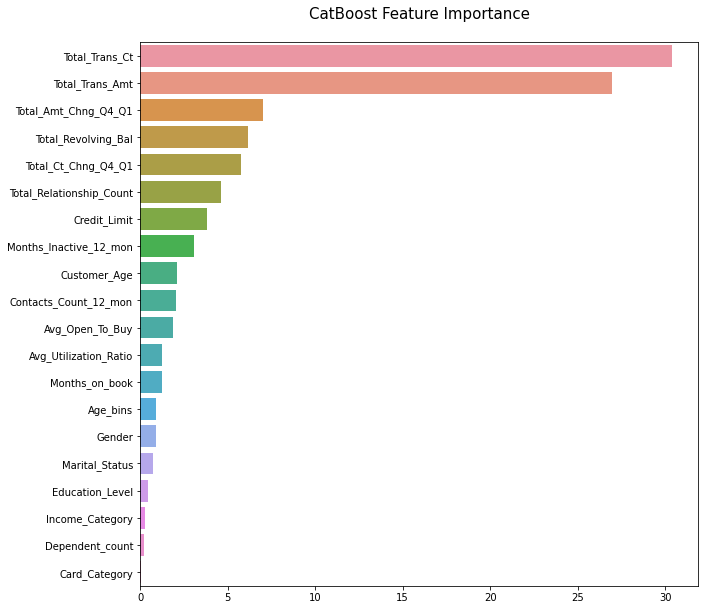

In [30]:
feature_importance = pd.Series(cat.feature_importances_, index=x_train.columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(feature_importance.values, feature_importance.index)
plt.title('CatBoost Feature Importance\n', fontsize=15)

In [39]:
columns = ['Attrited Customer', 'Existing Customer']
df = pd.DataFrame(columns=columns)

x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.fit_transform(x_test)
df.loc['Before Sampling'] = [sum(y_train==0), sum(y_train==1)]

tl = TomekLinks()
x_train_ss, y_train = tl.fit_resample(x_train_ss, y_train)
df.loc['After Sampling'] = [sum(y_train==0), sum(y_train==1)]
print('TomekLinks Before After Data Compare')
df



TomekLinks Before After Data Compare


Attrited Customer  Existing Customer
Before Sampling               1300               6801
After Sampling                1300               6662